In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
def preparedata(file):
    cloud_cover = pd.read_csv(file, skipinitialspace = True)
    cloud_cover['Date'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
    cloud_cover['Time'] = cloud_cover[['Hour']].apply(lambda x: "{}".format(str(x[0]).zfill(2)), axis=1)
    cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)  
    cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
    cloud_cover = cloud_cover.groupby(['Date', 'Time']).agg(cloud_cover=('cloud_cover','mean')).reset_index()
    cloud_cover['DateTime'] = cloud_cover[['Date', 'Time']].apply(lambda x: "{} {}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Date", "Time"], axis=1, inplace=True)        
    cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d %H:%M")
    cloud_cover.dropna(inplace=True)
    return cloud_cover

In [11]:
def split_train_test(data, n_steps):
	X, y = [], []
	for i in range(n_steps, len(data)):
		X.append(data[i-n_steps:i])
		y.append(data[i])
	return np.array(X), np.array(y)

In [4]:
def plot_curve(history):
    print('Last train loss: %s'%history.history['loss'][-1])
    print('Last validation loss: %s'%history.history['val_loss'][-1])
    print('Last train accuracy: %s'%history.history['accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_accuracy'][-1])
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    fig = plt.figure(figsize=[8,6])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'orange', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()  

In [5]:
def compare_mse_model(model,model_1):
    mse_error = [model,model_1]
    error = pd.DataFrame({"Model" : ['model','model_1'], "MSE error": mse_error})
    return error

In [6]:
def Xtrain_ytrain(train,test,spilt):
    #scale train
    sc = MinMaxScaler()
    sc.fit(train)
    train_set_scale = sc.transform(train)
    # train
    X_train, y_train = split_train_test(train_set_scale, spilt)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print("X_train Shape :", X_train.shape)
    print("y_train Shape :", y_train.shape)

    #scale test
    dataset_total = pd.concat((train['cloud_cover'], test['cloud_cover']), axis=0)
    inputs = dataset_total[len(dataset_total) - len(test) - spilt:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    # test
    X_test, y_test = split_train_test(inputs, spilt)
    print("X_test Shape : ", X_test.shape)
    print("y_test Shape : ", y_test.shape)
    return X_train, y_train, X_test, y_test, sc

In [10]:
cloud_cover = preparedata('../succeed-prophet/Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv')
cloud_cover.dtypes

cloud_cover           float64
DateTime       datetime64[ns]
dtype: object

# Train/test

In [8]:
train, test = cloud_cover,cloud_cover

train = train.set_index('DateTime')
test = test.set_index('DateTime')

X_train, y_train, X_test, y_test , sc= Xtrain_ytrain(train,test,1)

X_train Shape : (255, 1, 1)
y_train Shape : (255, 1)
X_test Shape :  (256, 1, 1)
y_test Shape :  (256, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [9]:
train.dtypes

cloud_cover    float64
dtype: object

## Add frist layer: units = 50 and change epochs from 30 to 50

In [55]:
regressor_3 = Sequential()
regressor_3.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
regressor_3.add(Dense(units = 1))
regressor_3.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [56]:
hist_3 = regressor_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 50, batch_size = 32)

Epoch 1/50
8/8 [==============================] - 4s 110ms/step - loss: 0.3129 - accuracy: 0.0039 - val_loss: 0.2924 - val_accuracy: 0.0039
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.2727 - accuracy: 0.0039 - val_loss: 0.2541 - val_accuracy: 0.0039
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.2366 - accuracy: 0.0039 - val_loss: 0.2187 - val_accuracy: 0.0039
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.2023 - accuracy: 0.0039 - val_loss: 0.1869 - val_accuracy: 0.0039
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.1719 - accuracy: 0.0039 - val_loss: 0.1582 - val_accuracy: 0.0039
Epoch 6/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1454 - accuracy: 0.0039 - val_loss: 0.1326 - val_accuracy: 0.0039
Epoch 7/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1206 - accuracy: 0.0039 - val_loss: 0.1116 - val_accuracy: 0.0039
Epoch 8/50
8/8 [==========

Last train loss: 0.036459505558013916
Last validation loss: 0.03867320343852043
Last train accuracy: 0.007843137718737125
Last validation accuracy: 0.0078125


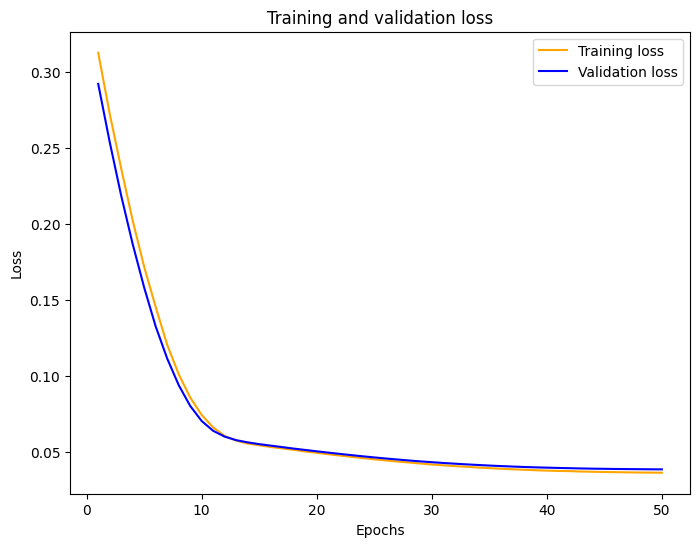

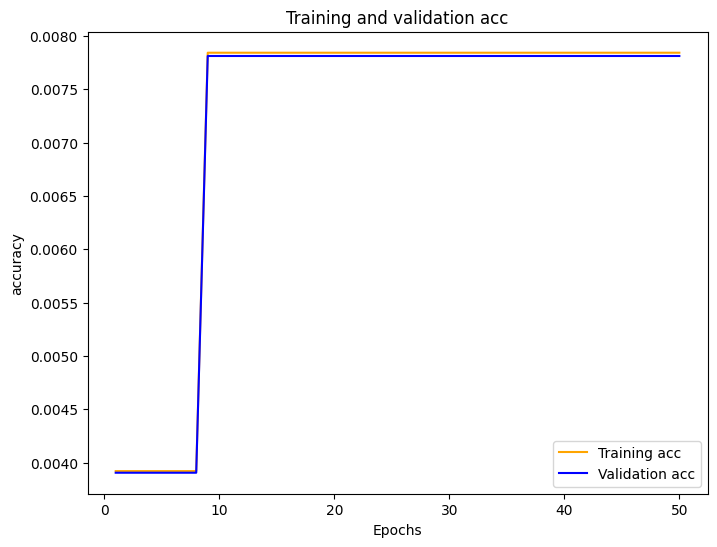

In [57]:
plot_curve(hist_3)

In [58]:
predict_scaled_3 = regressor_3.predict(X_test)
predict_3 = sc.inverse_transform(predict_scaled_3)
predict_3

8/8 [==============================] - 1s 2ms/step


array([[0.2238768 ],
       [0.89407563],
       [0.8785231 ],
       [0.8676104 ],
       [0.8228069 ],
       [0.5904908 ],
       [0.26735717],
       [0.23682523],
       [0.21695517],
       [0.40034074],
       [0.57873476],
       [0.53951085],
       [0.5594867 ],
       [0.43346906],
       [0.29555592],
       [0.21738583],
       [0.8567811 ],
       [0.8323643 ],
       [0.7843579 ],
       [0.7556255 ],
       [0.83928   ],
       [0.85721076],
       [0.7755851 ],
       [0.6139267 ],
       [0.85846525],
       [0.7694195 ],
       [0.51531243],
       [0.45010915],
       [0.64214563],
       [0.6962167 ],
       [0.6397055 ],
       [0.4635236 ],
       [0.30042797],
       [0.16054423],
       [0.15824507],
       [0.27429923],
       [0.48051575],
       [0.674446  ],
       [0.6902211 ],
       [0.69562006],
       [0.45665094],
       [0.40004602],
       [0.2553909 ],
       [0.67117107],
       [0.5537451 ],
       [0.37094668],
       [0.38720667],
       [0.489

In [59]:
test['LSTM'] = predict_3
test

,cloud_cover,LSTM
DateTime,,
2021-11-16 11:00:00,0.990899,0.223877
2021-11-16 12:00:00,0.973114,0.894076
2021-11-16 13:00:00,0.960600,0.878523
2021-11-16 14:00:00,0.908915,0.867610
2021-11-16 15:00:00,0.631449,0.822807
...,...,...
2021-12-16 10:00:00,0.480200,0.235378
2021-12-16 11:00:00,0.155117,0.470441
2021-12-16 12:00:00,0.161317,0.230677


In [60]:
train1 = train.copy()
test1 = test.copy()
train1.reset_index(inplace=True)
test1.reset_index(inplace=True)

In [61]:
train

,cloud_cover
DateTime,
2021-11-16 11:00:00,0.990899
2021-11-16 12:00:00,0.973114
2021-11-16 13:00:00,0.960600
2021-11-16 14:00:00,0.908915
2021-11-16 15:00:00,0.631449
...,...
2021-12-16 10:00:00,0.480200
2021-12-16 11:00:00,0.155117
2021-12-16 12:00:00,0.161317


In [62]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train1['DateTime'], y = train1['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test1['DateTime'], y = test1['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test1['DateTime'], y = test1['LSTM'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [63]:
lstm_mse_error = mean_squared_error(test['cloud_cover'], test['LSTM'], squared=True)
lstm_mse_error

0.03696887166333343